In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException    
import re
import pandas as pd
import time
import datetime
import sqlite3

In [7]:
options = webdriver.ChromeOptions()
#options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument("--start-maximized")
PATH = r"C:\Users\grego\Dev\Data and IR\Abstimmungsverhalten_v2\chromedriver_win32.exe"

# Getting link list (we maybe could write this a as a function elsewhere and just call it here)

# Set up the webdriver
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(options=options)


In [8]:
# Navigate to the relevant page
driver.get("https://www.bundestag.de/abgeordnete/biografien")

# Expand the page to show all MPs
button = driver.find_element(By.CSS_SELECTOR, '.bt-link-list[href="javascript:void(0);"]')
button.click()
time.sleep(5)

# Get the links of all MPs
try:
    links = [i.get_attribute('href') for i in driver.find_elements(By.CSS_SELECTOR, 'a[href^="/abgeordnete"]')]
    print('Success!!!')
    print(f'Found {len(links)} links.')
except Exception as e:
    print('Error:', e)

# Quit the webdriver
driver.quit()


Success!!!
Found 777 links.


In [9]:
# working with the links liste generated above. we need to filter out the wrong links first before iterating over it and fetching the relevant information

regex = 'biografien\/[a-zA-Z]\/'

falsche_links = []
richtige_links = []

for lnk in links:
    if bool(re.search(regex, lnk)):
        richtige_links.append(lnk)
    else:
        falsche_links.append(lnk)

print(len(falsche_links))
print(len(richtige_links))

18
759


In [10]:
# thinking how to include vote retrieval

def retrieve_votes(lnk):
    df_abstimmungen_selenium = pd.DataFrame()
    
    def check_abstimmungen_exists():
        try:
            driver.find_element(By.LINK_TEXT, 'Abstimmungen')
        except NoSuchElementException:
            return False
        return True
    
    driver.get(lnk)
    if check_abstimmungen_exists() == True:
        try:
            link = driver.find_element(By.LINK_TEXT, 'Abstimmungen')
            link.click()

            link = driver.find_element(By.CSS_SELECTOR, 'button.bt-button.bt-button--icon-right.bt-button--show-more.loadMore[type="submit"]')
            link.click()

            page_source = driver.page_source
            table = pd.read_html(page_source)

            df = table[0]
            id_stripped = re.findall("\d+", str(lnk))
            df['bundestags_id'] = id_stripped[0]
            data = df.iloc[:-1 , :]

            df_abstimmungen_selenium = df_abstimmungen_selenium.append(data,ignore_index=True)

        except Exception as e:
                #driver.quit()
                print('duh!!!!!')
                print('Error:', e)

    else:
        data = ['Keine Abstimmungen']
        df_abstimmungen_selenium = df_abstimmungen_selenium.append(data,ignore_index=True)

    return df_abstimmungen_selenium


In [11]:
#creating the lists that eventually will form the dataframe

bundestags_id = []
wahlkreis = []
nachnamen = []
vornamen = []
facebook_links = []
instagram_links = []
twitter_links = []
website_links = []
partei_links = []
img_url = []
beruf_text = []

df_politiker_selenium = pd.DataFrame()
df_abstimmungen_selenium = pd.DataFrame()

In [12]:
start_time = time.time()


#iterating over all  pages and getting the relevant information into df
driver = webdriver.Chrome(options=options)

# to verify the existence of elements

def check_link_exists(link_text):
    try:
        driver.find_element(By.CSS_SELECTOR, f'.bt-link-extern[title^="{link_text}"]')
    except NoSuchElementException:
        return False
    return True

def check_abstimmungen_exists():
    try:
        driver.find_element(By.LINK_TEXT, 'Abstimmungen')
    except NoSuchElementException:
        return False
    return True

def check_partei_exists():
    try:
        driver.find_element(By.CSS_SELECTOR,'div.bt-logo-partei img')
    except NoSuchElementException:
        return False
    return True


#for test
i = 0




for lnk in richtige_links:
    driver.get(lnk)
    
    webpage_exists = check_link_exists("Homepage")
    facebook_exists = check_link_exists("Facebook")
    twitter_exists = check_link_exists("Twitter")
    instagram_exists = check_link_exists("Instagram")
    wahlkreis_exists = check_link_exists("Wahlkreis")
    partei_exists = check_partei_exists()

    try:
        #bundestags_id
        id_stripped = re.findall("\d+", lnk)
        bundestags_id.append(id_stripped[0])
        
        # names --- !!!! derzeit sind es nicht immer die korrekten namen. besser sie aus dem namenselement statt dem titel zu ziehen
        # NOCH UNKLAR: Welcher Name soll gewählt werden... in welchem Format. Hier scheinen Abweichungen auf der Website, bei manchen wird z.b. (Heilbronn) mitübergeben.
        get_title = driver.title
        nachnamen.append(re.findall("\w+", get_title)[-1])
        vornamen.append(re.findall("\w+", get_title)[-2])
        
        #Partei
        if check_partei_exists() == True:
            search = driver.find_element(By.CSS_SELECTOR,'div.bt-logo-partei img').get_attribute('alt')
            partei_links.append(search)
        else:
            partei_links.append('fraktionslos')
            
        #Beruf
        beruf = driver.find_element(By.CSS_SELECTOR, 'div.bt-biografie-beruf p').text
        beruf_text.append(beruf)

        # img_url
        base_url = "https://www.bundestag.de"
        url = driver.find_element(By.CSS_SELECTOR, 'img[data-img-md-retina]').get_attribute('data-img-md-retina')
        full_url = base_url + url
        img_url.append(full_url)

        # wahlkreis
        if wahlkreis_exists == True:
            search = driver.find_element(By.CSS_SELECTOR, '.bt-link-intern[title^="Wahlkreis"]').get_attribute('innerHTML')
            wahlkreis.append(search)
        else: #gibt mir das Bundesland
            search = driver.find_element(By.CSS_SELECTOR, '.bt-standard-content.col-sm-6.col-xs-12').get_attribute('innerHTML')
            land = re.findall('\>(.*)\<', search)
            wahlkreis.append('Landesliste:' + str(land))

        # links
        if webpage_exists == True:
            element = driver.find_element(By.CSS_SELECTOR, '.bt-link-extern[title^="Homepage"]')
            website_links.append(element.get_attribute('href'))
        else:
            website_links.append('keine auf Bundestagsseite')

        if facebook_exists == True:
            element = driver.find_element(By.CSS_SELECTOR, '.bt-link-extern[title^="Facebook"]')
            facebook_links.append(element.get_attribute('href'))
        else:
            facebook_links.append('keine auf Bundestagsseite')

        if twitter_exists == True:
            element = driver.find_element(By.CSS_SELECTOR, '.bt-link-extern[title^="Twitter"]')
            twitter_links.append(element.get_attribute('href'))
        else:
            twitter_links.append('keine auf Bundestagsseite')
            
        if instagram_exists == True:
            element = driver.find_element(By.CSS_SELECTOR, '.bt-link-extern[title^="Instagram"]')
            instagram_links.append(element.get_attribute('href'))
        else:
            instagram_links.append('keine auf Bundestagsseite')
       

    except Exception as e:
        #driver.quit()
        print('duh!!!!!')
        print(lnk)
        print('Error:', e)
    
    if check_abstimmungen_exists() == True:
        try:
            link = driver.find_element(By.LINK_TEXT, 'Abstimmungen')
            link.click()

            link = driver.find_element(By.CSS_SELECTOR, 'button.bt-button.bt-button--icon-right.bt-button--show-more.loadMore[type="submit"]')
            link.click()

            page_source = driver.page_source
            table = pd.read_html(page_source)

            df = table[0]
            id_stripped = re.findall("\d+", str(lnk))
            df['bundestags_id'] = id_stripped[0]
            data = df.iloc[:-1 , :]

            df_abstimmungen_selenium = df_abstimmungen_selenium.append(data,ignore_index=True)

        except Exception as e:
                #driver.quit()
                print('duh!!!!!')
                print(lnk)
                print('Error:', e)

    else:
        data = ['Keine Abstimmungen']
        df_abstimmungen_selenium = df_abstimmungen_selenium.append(data,ignore_index=True)
    
     # to test this loop with 5 iterations
    i = i + 1
    if i == 25:
       break



df_politiker_selenium['bundestags_id'] = bundestags_id
df_politiker_selenium['vorname'] = vornamen
df_politiker_selenium['nachname'] = nachnamen
df_politiker_selenium['wahlkreis'] = wahlkreis
df_politiker_selenium['facebook_links'] = facebook_links
df_politiker_selenium['twitter_links'] = twitter_links
df_politiker_selenium['website_links'] = website_links
df_politiker_selenium['instagram_links'] = instagram_links
df_politiker_selenium['img_url'] = img_url
df_politiker_selenium['partei'] = partei_links
df_politiker_selenium['beruf'] = beruf_text

end_time = time.time()
total_time = end_time - start_time

print("Time taken: ", total_time, "seconds")

Time taken:  76.71472215652466 seconds


In [ ]:
# df manipulation
df_politiker_selenium['wahlkreis'] = df_politiker_selenium['wahlkreis'].astype(str)
df_politiker_selenium['bundesland'] = df_politiker_selenium['wahlkreis'].str.extract(r"Landesliste:\[\'([\w\s\-–]+)", expand=False)
df_politiker_selenium['wahlkreis_id'] = df_politiker_selenium['wahlkreis'].str.extract(r"Wahlkreis\s(\d+:\s[\w\s\-–]+\w)\']")
df_politiker_selenium['partei'] = df_politiker_selenium['partei'].str.replace(r'^Wortbildmarke der\s*', '').str.strip()

df_politiker_selenium

In [13]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# save the dataframe to a CSV file with the timestamp in the filename
filename1 = f'csv/df_politiker_selenium_{timestamp}.csv'
filename2 = f'csv/df_abstimmungen_selenium_{timestamp}.csv'
df_politiker_selenium.to_csv(filename1, index=False)
df_abstimmungen_selenium.to_csv(filename2, index=False)

Index(['bundestags_id', 'vorname', 'nachname', 'wahlkreis', 'facebook_links',
       'twitter_links', 'website_links', 'instagram_links', 'img_url',
       'partei', 'beruf', 'bundesland', 'wahlkreis_id'],
      dtype='object')

In [180]:
df_politiker_selenium

,bundestags_id,vorname,nachname,wahlkreis,facebook_links,twitter_links,website_links,instagram_links,img_url,partei,beruf,bundesland,wahlkreis_id
0,861028,Sanae,Abdi,"Landesliste:['Nordrhein-Westfalen', 'Wahlkreis...",https://www.facebook.com/sanaeabdispd,https://twitter.com/abdisanae?lang=de,https://sanae-abdi.spd.de/,https://www.instagram.com/sanae_ccaa/,https://www.bundestag.de/resource/image/861934...,SPD-Bundestagsfraktion,Vertrags- und Finanzmanagerin,Nordrhein-Westfalen,093: Köln I
1,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
2,860100,Valentin,Abel,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/valentinabel.fdp,https://twitter.com/Valentin_C_Abel,https://www.valentin-abel.de/,https://www.instagram.com/valentin_christian_a...,https://www.bundestag.de/resource/image/862872...,FDP-Bundestagsfraktion,Kaufmännischer Angestellter,Baden-Württemberg,268: Schwäbisch Hall – Hohenlohe
3,860114,Al,Dailami,"Landesliste:['Hessen', 'Wahlkreis 173: Gießen']",keine auf Bundestagsseite,keine auf Bundestagsseite,keine auf Bundestagsseite,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/869866...,Bundestagsfraktion Die Linke.,Restaurantfachmann,Hessen,173: Gießen
4,860546,Knut,Abraham,"Landesliste:['Brandenburg', 'Wahlkreis 065: El...",https://facebook.com/knut.abraham,keine auf Bundestagsseite,https://knut-abraham.de/,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/861936...,CDU/CSU-Bundestagsfraktion,Diplomat,Brandenburg,065: Elbe-Elster – Oberspreewald-Lausitz II
5,860118,Al,Halak,"Landesliste:['Bayern', 'Wahlkreis 227: Deggend...",https://www.facebook.com/AlHalakMuhanad/,https://mobile.twitter.com/halakmuhanad,https://muhanad-al-halak.wahl.freie-demokraten...,https://www.instagram.com/al_halak_m/,https://www.bundestag.de/resource/image/861942...,FDP-Bundestagsfraktion,Abwassermeister,Bayern,227: Deggendorf
6,860102,Katja,Adler,"Landesliste:['Hessen', 'Wahlkreis 176: Hochtau...",https://facebook.com/katjadler,https://twitter.com/katjadler,http://www.katja-adler.eu/,https://www.instagram.com/katj_ad,https://www.bundestag.de/resource/image/861938...,FDP-Bundestagsfraktion,Beamtin,Hessen,176: Hochtaunus
7,860830,Alabali,Radovan,"Landesliste:['Mecklenburg-Vorpommern', 'Wahlkr...",https://www.facebook.com/reem.alabaliradovan,https://twitter.com/ReemAlabali,https://reem-alabali-radovan.spd.de/,https://www.instagram.com/reem.alabaliradovan/,https://www.bundestag.de/resource/image/869604...,SPD-Bundestagsfraktion,Politikwissenschaftlerin,Mecklenburg-Vorpommern,012: Schwerin – Ludwigslust-Parchim I – Nordwe...
8,860154,Stephanie,Aeffner,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/people/Stephanie-Aeff...,https://twitter.com/s_aeffner,https://aeffnerstephanie.de/,https://www.instagram.com/stephanie_aeffner/,https://www.bundestag.de/resource/image/861940...,Bundestagsfraktion Bündnis 90/Die Grünen,Diplom-Sozialarbeiterin (FH),Baden-Württemberg,279: Pforzheim
9,857088,Stephan,Albani,"Landesliste:['Niedersachsen', 'Wahlkreis 027: ...",https://www.facebook.com/StephanAlbaniMdB,keine auf Bundestagsseite,http://www.stephan-albani.de/,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/864084...,CDU/CSU-Bundestagsfraktion,Diplom-Physiker,Niedersachsen,027: Oldenburg – Ammerland


In [16]:
import sqlite3
import matplotlib.pyplot as plt


def get_db_connection():
    conn = sqlite3.connect('database.db')
    conn.row_factory = sqlite3.Row
    return conn

In [77]:
bundestags_id = 860546
conn = get_db_connection()
query = f"WITH abs AS (SELECT * FROM df_abstimmungen_selenium WHERE bundestags_id = {bundestags_id}), pol AS (SELECT * FROM df_politiker_selenium WHERE bundestags_id = {bundestags_id}) SELECT * FROM abs LEFT JOIN pol ON abs.bundestags_id = pol.bundestags_id"
data = conn.execute(query).fetchall()
df = pd.read_sql_query(query, conn)
df = df.groupby('Abstimmungsverhalten').size().reset_index(name='count')
df.columns


Index(['Abstimmungsverhalten', 'count'], dtype='object')

In [78]:
df

,Abstimmungsverhalten,count
0,Ja,36
1,Nein,44


([<matplotlib.patches.Wedge at 0xdeb7670>,
 [Text(0.17207795223283864, 1.086457168210212, 'Ja'),
  Text(-0.172077952232839, -1.086457168210212, 'Nein')],
 [Text(0.09386070121791197, 0.5926130008419338, '45.0%'),
  Text(-0.09386070121791217, -0.5926130008419338, '55.0%')])

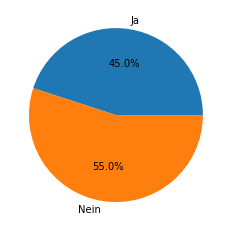

In [79]:
labels = df['Abstimmungsverhalten']
counts = df['count']
plt.pie(counts, labels=labels, autopct='%1.1f%%')

Text(1.1, 0.1, 'N (80)')

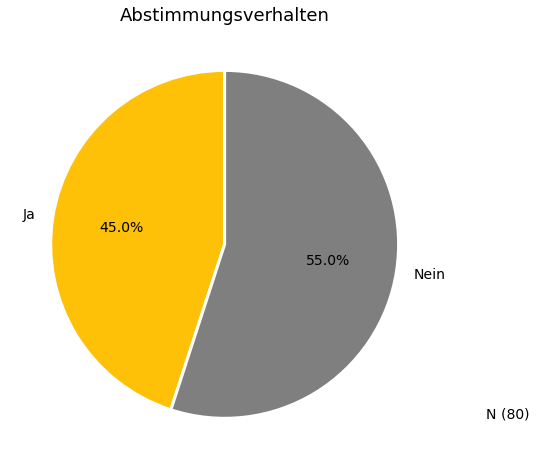

In [80]:
# specify custom colors
colors = ['#ffc107', '#7f7f7f', '#5a5a5a', '#1a1a1a']

# create a pie chart with custom colors
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))



ax.pie(df['count'], labels=df['Abstimmungsverhalten'], autopct='%1.1f%%',  startangle=90, wedgeprops={'linewidth': 3, 'edgecolor': 'w', 'antialiased': True}, textprops={'fontsize': 14} , colors=colors)
   

    
fig.set_size_inches(8, 8)
# set chart title
ax.set_title('Abstimmungsverhalten', fontsize=18)

# remove legend and add a text box
label = 'N ({})'.format(df['count'].sum())

ax.legend().remove()
ax.text(1.1, 0.1, label, fontsize=14, transform=ax.transAxes)



In [165]:
ax.pie(df['count'], labels=df['Abstimmungsverhalten'], startangle=90, autopct='%1.1f%%', pctdistance=0.75, labeldistance=1.05, wedgeprops={'linewidth': 3, 'edgecolor': 'w', 'antialiased': True}, textcoords='data')



TypeError: pie() got an unexpected keyword argument 'textcoords'

In [3]:
def get_db_connection():
    conn = sqlite3.connect('database.db')
    conn.row_factory = sqlite3.Row
    return conn


In [104]:
conn = get_db_connection()
query = f"WITH abs AS (SELECT * FROM df_abstimmungen_selenium WHERE bundestags_id = {bundestags_id}), pol AS (SELECT * FROM df_politiker_selenium WHERE bundestags_id = {bundestags_id}) SELECT * FROM abs LEFT JOIN pol ON abs.bundestags_id = pol.bundestags_id"
data = conn.execute(query).fetchall()
df = pd.DataFrame(data)
df.head(5)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,15.12.2022,Energiepreisbremse (Strompreisbremse),Nein,860546,None,860546,Knut,Abraham,"Landesliste:['Brandenburg', 'Wahlkreis 065: Elbe-Elster – Oberspreewald-Lausitz II']",https://facebook.com/knut.abraham,keine auf Bundestagsseite,https://knut-abraham.de/,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/861936/3x4/568/758/78214591bf344436613ca4fd179899f8/A17531AAF8905F1AFA48340204C05112/abraham_knut.jpg,CDU/CSU-Bundestagsfraktion,Diplomat,Brandenburg,065: Elbe-Elster – Oberspreewald-Lausitz II
1,15.12.2022,Energiepreisbremse (Strompreisbremse),Nein,860546,None,860546,Knut,Abraham,"Landesliste:['Brandenburg', 'Wahlkreis 065: Elbe-Elster – Oberspreewald-Lausitz II']",https://facebook.com/knut.abraham,keine auf Bundestagsseite,https://knut-abraham.de/,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/861936/3x4/568/758/78214591bf344436613ca4fd179899f8/A17531AAF8905F1AFA48340204C05112/abraham_knut.jpg,CDU/CSU-Bundestagsfraktion,Diplomat,Brandenburg,065: Elbe-Elster – Oberspreewald-Lausitz II
2,15.12.2022,Energiepreisbremse,Nein,860546,None,860546,Knut,Abraham,"Landesliste:['Brandenburg', 'Wahlkreis 065: Elbe-Elster – Oberspreewald-Lausitz II']",https://facebook.com/knut.abraham,keine auf Bundestagsseite,https://knut-abraham.de/,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/861936/3x4/568/758/78214591bf344436613ca4fd179899f8/A17531AAF8905F1AFA48340204C05112/abraham_knut.jpg,CDU/CSU-Bundestagsfraktion,Diplomat,Brandenburg,065: Elbe-Elster – Oberspreewald-Lausitz II
3,15.12.2022,Energiepreisbremse,Nein,860546,None,860546,Knut,Abraham,"Landesliste:['Brandenburg', 'Wahlkreis 065: Elbe-Elster – Oberspreewald-Lausitz II']",https://facebook.com/knut.abraham,keine auf Bundestagsseite,https://knut-abraham.de/,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/861936/3x4/568/758/78214591bf344436613ca4fd179899f8/A17531AAF8905F1AFA48340204C05112/abraham_knut.jpg,CDU/CSU-Bundestagsfraktion,Diplomat,Brandenburg,065: Elbe-Elster – Oberspreewald-Lausitz II
4,02.12.2022,Jahressteuergesetz 2022 (Artikel 29 und 40),Nein,860546,None,860546,Knut,Abraham,"Landesliste:['Brandenburg', 'Wahlkreis 065: Elbe-Elster – Oberspreewald-Lausitz II']",https://facebook.com/knut.abraham,keine auf Bundestagsseite,https://knut-abraham.de/,keine auf Bundestagsseite,https://www.bundestag.de/resource/image/861936/3x4/568/758/78214591bf344436613ca4fd179899f8/A17531AAF8905F1AFA48340204C05112/abraham_knut.jpg,CDU/CSU-Bundestagsfraktion,Diplomat,Brandenburg,065: Elbe-Elster – Oberspreewald-Lausitz II


In [140]:
bundestags_id = 860154

In [141]:
conn = get_db_connection()

query = f"SELECT * FROM df_politiker_selenium WHERE bundestags_id = {bundestags_id}"
result = conn.execute(query)

# Get the column names of the query result
columns = [col[0] for col in result.description]

# Fetch the first row of the query result as a dictionary
data = dict(zip(columns, result.fetchone()))

data

{'bundestags_id': '860154',
 'vorname': 'Stephanie',
 'nachname': 'Aeffner',
 'wahlkreis': "Landesliste:['Baden-Württemberg', 'Wahlkreis 279: Pforzheim']",
 'facebook_links': 'https://www.facebook.com/people/Stephanie-Aeffner/100084209227731/',
 'twitter_links': 'https://twitter.com/s_aeffner',
 'website_links': 'https://aeffnerstephanie.de/',
 'instagram_links': 'https://www.instagram.com/stephanie_aeffner/',
 'img_url': 'https://www.bundestag.de/resource/image/861940/3x4/568/758/b0a4aa7dd1ff57fc0b22878ac8f7302e/0AAD5E3DB1879D268533188B30E89040/aeffner_stephanie.jpg',
 'partei': 'Bundestagsfraktion Bündnis 90/Die Grünen',
 'beruf': 'Diplom-Sozialarbeiterin (FH)',
 'bundesland': 'Baden-Württemberg',
 'wahlkreis_id': '279: Pforzheim'}

In [163]:
bundestags_id= 857082
query5 = f"WITH abs AS (SELECT * FROM df_abstimmungen_selenium WHERE bundestags_id = {bundestags_id}), pol AS (SELECT * FROM df_politiker_selenium WHERE bundestags_id = {bundestags_id}), alldata AS (SELECT * FROM abs LEFT JOIN pol ON abs.bundestags_id = pol.bundestags_id) SELECT DISTINCT * FROM alldata WHERE Abstimmungsverhalten == 'Nicht abg.' "

data5 = pd.read_sql_query(query5, conn)
#data5 = data5.drop_duplicates()
data5


,Veröffentlichung,Abstimmungsthema,Abstimmungsverhalten,bundestags_id,0,bundestags_id:1,vorname,nachname,wahlkreis,facebook_links,twitter_links,website_links,instagram_links,img_url,partei,beruf,bundesland,wahlkreis_id
0,25.11.2022,Beschlussempfehlung Vermittlungsausschuss - Bürgergeld,Nicht abg.,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 275: Mannheim']",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_linke/?hl=de,https://www.bundestag.de/resource/image/864082/3x4/568/758/c013c6f333844c5fe13c9ec9d478524d/8803B3F801091F1952B2D36A22E167F6/akbulut_gokay_gross.jpg,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
1,10.11.2022,Einsprüche anlässlich der Wahl zum 20. Deutschen Bundestag,Nicht abg.,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 275: Mannheim']",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_linke/?hl=de,https://www.bundestag.de/resource/image/864082/3x4/568/758/c013c6f333844c5fe13c9ec9d478524d/8803B3F801091F1952B2D36A22E167F6/akbulut_gokay_gross.jpg,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim


In [48]:
pd.set_option("display.max_colwidth", None)
ralph_rows = data[data["nachname"].str.contains("Annen", case=False)]
ralph_rows

,bundestags_id,vorname,nachname,wahlkreis,facebook_links,twitter_links,website_links,instagram_links,img_url,partei,beruf,bundesland,wahlkreis_id
28,857106,Niels,Annen,"Landesliste:['Hamburg', 'Wahlkreis 020: Hamburg-Eimsbüttel']",https://www.facebook.com/nielsannen,https://twitter.com/NielsAnnen,https://www.nielsannen.de/,https://www.instagram.com/nielsannen/,https://www.bundestag.de/resource/image/864074/3x4/568/758/f02edc5dbec51139795dfc21fae115e4/B042C8C62828BFBD55EADC63D28B3B1F/annen_niels_bild.jpg,SPD-Bundestagsfraktion,"Historiker, Politikwissenschaftler (M.I.P.P.)",Hamburg,020: Hamburg-Eimsbüttel


In [27]:
conn = get_db_connection()

bundestags_id = 857082

# data body
query = f"WITH abs AS (SELECT * FROM df_abstimmungen_selenium WHERE bundestags_id = {bundestags_id}), pol AS (SELECT * FROM df_politiker_selenium WHERE bundestags_id = {bundestags_id}) SELECT * FROM abs LEFT JOIN pol ON abs.bundestags_id = pol.bundestags_id"
data = pd.read_sql_query(query, conn)
data = data.drop_duplicates()
data

,Veröffentlichung,Abstimmungsthema,Abstimmungsverhalten,bundestags_id,0,bundestags_id,vorname,nachname,wahlkreis,facebook_links,twitter_links,website_links,instagram_links,img_url,partei,beruf,bundesland,wahlkreis_id
0,15.12.2022,Energiepreisbremse (Strompreisbremse),Enthalten,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
2,15.12.2022,Energiepreisbremse,Enthalten,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
4,02.12.2022,Jahressteuergesetz 2022 (Artikel 29 und 40),Enthalten,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
6,02.12.2022,Aufenthaltsgesetz,Enthalten,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
8,01.12.2022,Braunkohleausstieg,Nein,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
10,01.12.2022,Änderung des Grundgesetzes (Artikel 82),Ja,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
12,01.12.2022,Transatlantisches Wirtschafts- und Handelsabko...,Nein,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
14,25.11.2022,Haushaltsgesetz 2023,Nein,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb_lin...,https://www.bundestag.de/resource/image/864082...,Bundestagsfraktion Die Linke.,Sozialwissenschaftlerin,Baden-Württemberg,275: Mannheim
16,25.11.2022,Beschlussempfehlung Vermittlungsausschuss - Bü...,Nicht abg.,857082,None,857082,Gökay,Akbulut,"Landesliste:['Baden-Württemberg', 'Wahlkreis 2...",https://www.facebook.com/gokay.akbulut.146,https://twitter.com/akbulutgokay?lang=de,https://goekay-akbulut.de/,https://www.instagram.com/gokayakbulut_mdb

In [37]:
conn = get_db_connection()

query = f"SELECT DISTINCT Abstimmungsthema, COUNT(*) FROM df_abstimmungen_selenium GROUP BY 1"
data = pd.read_sql_query(query, conn)
data = data.drop(index=0).reset_index(drop=True)
data['Abstimmungsthema']

0             Abschaffung der sachgrundlosen Befristung
1     Abschiebung nach Afghanistan, Beschlussempfehl...
2                 Anpassung des Verfassungsschutzrechts
3     Antrag zur Verlegung des Bundeswehrkontingents...
4     Artikel 1 Nummer 1 des Gesetzentwurfs in der A...
                            ...                        
76    Änderung von Artikel 21 des Grundgesetzes (Par...
77            Änderung von Artikel 90 des Grundgesetzes
78    Änderung von Artikel 90 und Artikel 143e des G...
79    Änderung von Artikel 91 b und Artikel 104c des...
80    Änderungsantrag der Fraktion Die Linke zur Neu...
Name: Abstimmungsthema, Length: 81, dtype: object

In [ ]:
# creating the visuals
   
    df = df.groupby('Abstimmungsverhalten').size().reset_index(name='count')
    colors = ['#ffc107', '#28a745', '#dc3545', '#6c757d']

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

    ax.pie(df['count'], labels=df['Abstimmungsverhalten'], autopct='%1.1f%%',  startangle=90, wedgeprops={'linewidth': 3, 'edgecolor': 'k', 'antialiased': True}, textprops={'fontsize': 18} , colors=colors)

    label = 'N ({})'.format(df['count'].sum())

    fig.set_facecolor('#ffc107')
    ax.set_title('Abstimmungsverhalten', fontsize=24, fontweight='bold')

In [1]:
import requests
import pandas as pd
import csv
import json

In [ ]:
## '47930567748 (SPD), 78502295414 (CDU), 47217143218 (Grüne), ||| 21289227249 (FDP), 47694585682 (Linke), 540404695989874 (AFD)

params = {
    'access_token': 'EAAMzOvy3c4cBABNZBuk271UbzC51ZABUygCxJp4RkBadWeHaohbmfxMmADyFSs74G3JPLsBSvuLg3r8HOfKnMkvCCW0ZCMwFhwhrEZC9ZAbSMn9GmJAb69MmsGjEx4DxNwcaXpMz6oN2A99esVfupZBrllwBiza3obiWqdpfDtYIEgbrOQZAL22m1ty1cx5Nj50rBzBtjhP4QZDZD',
    'ad_type': 'POLITICAL_AND_ISSUE_ADS',
    'ad_active_status': 'ALL',
    'ad_reached_countries': "['DE']",
    'ad_delivery_date_min': '2021-01-01',
    'search_page_ids': '47930567748, 78502295414, 47217143218',
    'fields': "ad_creative_body, ad_delivery_start_time, funding_entity, page_id, page_name, delivery_by_region, demographic_distribution, potential_reach, spend, impression", ### Q how to get demographic distribution
    'limit': '5000'
}

In [ ]:
https://graph.facebook.com/{api-endpoint}&access_token=900753371132807|21d3117f6e50dda861f62e63b795f23c
    


In [16]:
driver.get("https://www.facebook.com/Dr.Bernd.Baumann/")

In [32]:
from selenium.webdriver.common.by import By
element = driver.find_element(By.CSS_SELECTOR, "[aria-label='Allow essential and optional cookies']")
element.click()


ElementNotInteractableException: Message: element not interactable
  (Session info: chrome=111.0.5563.65)
Stacktrace:
Backtrace:
	(No symbol) [0x00D5E3E3]
	(No symbol) [0x00CF3B31]
	(No symbol) [0x00C04EB0]
	(No symbol) [0x00C312C6]
	(No symbol) [0x00C28F15]
	(No symbol) [0x00C4B0BC]
	(No symbol) [0x00C28936]
	(No symbol) [0x00C4B414]
	(No symbol) [0x00C5D77C]
	(No symbol) [0x00C4AEB6]
	(No symbol) [0x00C27178]
	(No symbol) [0x00C282DD]
	GetHandleVerifier [0x00FD3D32+2505650]
	GetHandleVerifier [0x010092A5+2724133]
	GetHandleVerifier [0x0100DE3C+2743484]
	GetHandleVerifier [0x00E05B30+612784]
	(No symbol) [0x00CFC852]
	(No symbol) [0x00D02128]
	(No symbol) [0x00D0220B]
	(No symbol) [0x00D0C9EB]
	BaseThreadInitThunk [0x770A00F9+25]
	RtlGetAppContainerNamedObjectPath [0x771E7BBE+286]
	RtlGetAppContainerNamedObjectPath [0x771E7B8E+238]


In [17]:
conn = get_db_connection()
query = f"SELECT DISTINCT partei FROM df_politiker_selenium"
df = pd.read_sql_query(query, conn)

In [18]:
df

,partei
0,SPD-Bundestagsfraktion
1,Bundestagsfraktion Die Linke.
2,FDP-Bundestagsfraktion
3,CDU/CSU-Bundestagsfraktion
4,Bundestagsfraktion Bündnis 90/Die Grünen
5,AfD-Bundestagsfraktion
6,fraktionslos


In [19]:
partei_list = df['partei'].tolist()

# print the list
print(partei_list)

['SPD-Bundestagsfraktion', 'Bundestagsfraktion Die Linke.', 'FDP-Bundestagsfraktion', 'CDU/CSU-Bundestagsfraktion', 'Bundestagsfraktion Bündnis 90/Die Grünen', 'AfD-Bundestagsfraktion', 'fraktionslos']
